In [85]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

Data italského rozšíření nemoci Covid-19 z veřejné databáze, updatované

In [86]:
url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
df = pd.read_csv(url)

In [87]:
df

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
0,2020-02-24 18:00:00,ITA,101,26,127,94,221,221,1,7,229,4324
1,2020-02-25 18:00:00,ITA,114,35,150,162,311,90,1,10,322,8623
2,2020-02-26 18:00:00,ITA,128,36,164,221,385,74,3,12,400,9587
3,2020-02-27 18:00:00,ITA,248,56,304,284,588,203,45,17,650,12014
4,2020-02-28 18:00:00,ITA,345,64,409,412,821,233,46,21,888,15695
5,2020-02-29 18:00:00,ITA,401,105,506,543,1049,228,50,29,1128,18661
6,2020-03-01 18:00:00,ITA,639,140,779,798,1577,528,83,34,1694,21127
7,2020-03-02 18:00:00,ITA,742,166,908,927,1835,258,149,52,2036,23345
8,2020-03-03 18:00:00,ITA,1034,229,1263,1000,2263,428,160,79,2502,25856
9,2020-03-04 18:00:00,ITA,1346,295,1641,1065,2706,443,276,107,3089,29837


Příprava dat, změna datumu na pořadové číslo.

In [88]:
df = df.loc[:,['data','totale_casi']]
FMT = '%Y-%m-%d %H:%M:%S'
date = df['data']
df['data'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01 00:00:00", FMT)).days  )

Data pro ČR zdroj https://www.kurzy.cz/zpravy/533079-mapa-koronaviru-aktualni-mapy-vyskytu-potvrzenych-pripadu-koronaviru-covid-19-mapa-koronaviru-v/
12.3.2020, 1816, 1722, 113
11.3.2020, 1358, 1294, 94
10.3.2020 	1193 	1153 	63
9.3.2020 	928 	896 	38
8.3.2020 	787 	761 	32
7.3.2020 	594 	575 	26
6.3.2020 	483 	471 	19
5.3.2020 	407 	399 	8
4.3.2020 	340 	335 	5
3.3.2020 	262 	257 	5
2.3.2020 	211 	208 	3
1.3.2020 	200 	197 	3

Logistický model

$$ f(x,a,b,c)= \frac{c}{1+e^\frac{-(x-b)}{a} } $$

* $x$ time
* $a$ rychlost infekce
* $b$ den zaznamenáno nejvíce nakažených
* $c$ konečný celkový počet nakažených


In [89]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

In [90]:
x = list(df.iloc[:,0])
y = list(df.iloc[:,1])
fit = curve_fit(logistic_model,x,y,p0=[2,100,20000])

In [91]:
fit

(array([4.11962741e+00, 7.35212155e+01, 4.23934824e+04]),
 array([[3.47661988e-02, 2.22046186e-01, 1.37666032e+03],
        [2.22046186e-01, 1.55028784e+00, 9.79578939e+03],
        [1.37666032e+03, 9.79578939e+03, 6.22330514e+07]]))

In [92]:
errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]


In [93]:
errors


[0.18645696231739362, 1.2451055543624405, 7888.79277456696]

In [94]:
(a,b,c)=(fit[0][0],fit[0][1],fit[0][2])

print(a,b,c)


4.119627409077726 73.52121553816296 42393.482426487004


In [95]:
sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))

In [96]:
sol

120

exponential function

In [97]:
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))
exp_fit = curve_fit(exponential_model,x,y,p0=[1,1,1])

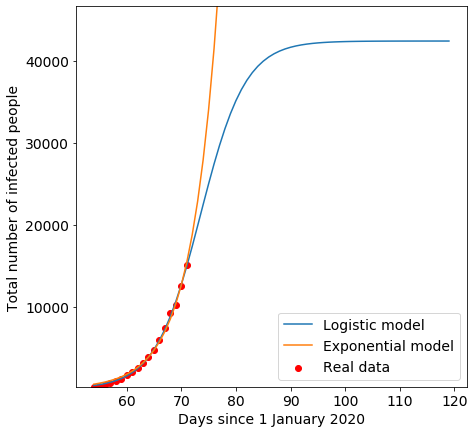

In [98]:
pred_x = list(range(max(x),sol))
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)
# Real data
plt.scatter(x,y,label="Real data",color="red")
# Predicted logistic curve
plt.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Logistic model" )

# Predicted exponential curve
plt.plot(x+pred_x, [exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) for i in x+pred_x], label="Exponential model" )
plt.legend()
plt.xlabel("Days since 1 January 2020")
plt.ylabel("Total number of infected people")
plt.ylim((min(y)*0.9,c*1.1))
plt.show()

In [110]:
print('Logistický model pro Itálii predikuje konec infekce v den ',sol,' od 1.1.2020 s celkem ',int(c),'(+-', int(errors[2]),') nakaženými. ')

Logistický model pro Itálii predikuje konec infekce v den  120  od 1.1.2020 s celkem  42393 (+- 7888 ) nakaženými. 


Data v CR

In [113]:
crdata=[['days','infected'],[61,3],[62,3],[63,5],[64,5],[65,8],[66,19],[67,26],[68,32],[69,38],[70,63],[71,94],[72,113]]
#12.3.2020, 1816, 1722, 113
#11.3.2020, 1358, 1294, 94
#10.3.2020 	1193 	1153 	63
#9.3.2020 	928 	896 	38
#8.3.2020 	787 	761 	32
#7.3.2020 	594 	575 	26
#6.3.2020 	483 	471 	19
#5.3.2020 	407 	399 	8
#4.3.2020 	340 	335 	5
#3.3.2020 	262 	257 	5
#2.3.2020 	211 	208 	3
#1.3.2020 	200 	197 	3
# 1.3. je den cislo 61 od 1.1.2020(prestupny rok)

In [114]:
df2 = pd.DataFrame(crdata[1:],columns=crdata[0])

In [115]:
df2

,days,infected
0,61,3
1,62,3
2,63,5
3,64,5
4,65,8
5,66,19
6,67,26
7,68,32
8,69,38
9,70,63


In [116]:
x2 = list(df2.iloc[:,0])
y2 = list(df2.iloc[:,1])
fit2 = curve_fit(logistic_model,x2,y2,p0=[2,100,20000])
exp_fit2 = curve_fit(exponential_model,x2,y2,p0=[0.02,0.1,2.8])

In [117]:
exp_fit2

(array([5.51988217e-05, 3.27128432e-01, 2.74432333e+01]),
 array([[-1.39173282e+04, -6.80056305e-01, -7.70085347e+08],
        [-6.80056305e-01,  3.03746698e-04, -3.76294045e+04],
        [-7.70085347e+08, -3.76294045e+04, -4.26110122e+13]]))

In [118]:
(a2,b2,c2)=(fit2[0][0],fit2[0][1],fit2[0][2])

In [119]:
print(a2,b2,c2)


2.438808169047471 73.30708276170846 312.7078657191373


In [120]:
sol2= int(fsolve(lambda x : logistic_model(x,a2,b2,c2) - int(c2),b2))

In [121]:
errors2 = [np.sqrt(fit2[1][i][i]) for i in [0,1,2]]

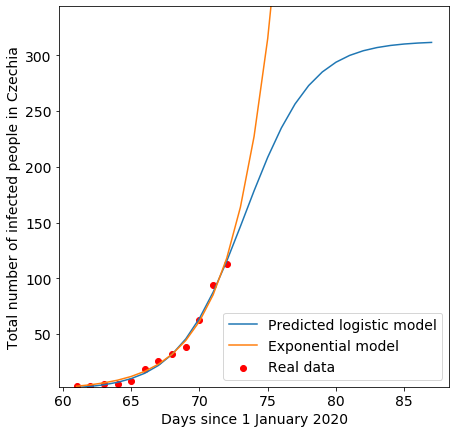

Logistický model pro ČR predikuje konec infekce v den  88  od 1.1.2020 s celkem  312 (+- 166 ) nakaženými. 


In [122]:
pred_x = list(range(max(x2),sol2))
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)
# Real data
plt.scatter(x2,y2,label="Real data",color="red")
# Predicted logistic curve
plt.plot(x2+pred_x, [logistic_model(i,fit2[0][0],fit2[0][1],fit2[0][2]) for i in x2+pred_x], label="Predicted logistic model" )

# Predicted exponential curve
plt.plot(x2+pred_x, [exponential_model(i,exp_fit2[0][0],exp_fit2[0][1],exp_fit2[0][2]) for i in x2+pred_x], label="Exponential model" )
plt.legend()
plt.xlabel("Days since 1 January 2020")
plt.ylabel("Total number of infected people in Czechia")
plt.ylim((min(y2)*0.9,c2*1.1))
plt.show()
print('Logistický model pro ČR predikuje konec infekce v den ',sol2,' od 1.1.2020 s celkem ',int(c2),'(+-', int(errors2[2]),') nakaženými. ')

Reference:
* modely a data z Itálie https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d
* 